<a href="https://colab.research.google.com/github/xh313/TidyTuesdayWithPython/blob/main/TidyTuesday12072022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install basemap
!pip install geopy

import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns
import numpy as np
import matplotlib.animation as animation
from matplotlib.colors import LogNorm
from matplotlib import font_manager as fm
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from matplotlib.lines import Line2D


!pip install colour
import colour
from matplotlib.colors import ListedColormap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 863 kB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 33.9 MB/s 
     |████████████████████████████████| 219 kB 45.0 MB/s 
     |████████████████████████████████| 30.5 MB 1.6 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=74a1da6a9b804d5013543feab86034c4f51f93e7aebbc46e6c29b942bcfbe52a
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Palette
!wget 'https://github.com/BlakeRMills/MetBrewer/raw/main/Python/met_brewer/palettes.py'
import palettes as met

--2022-07-13 02:00:24--  https://github.com/BlakeRMills/MetBrewer/raw/main/Python/met_brewer/palettes.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BlakeRMills/MetBrewer/main/Python/met_brewer/palettes.py [following]
--2022-07-13 02:00:24--  https://raw.githubusercontent.com/BlakeRMills/MetBrewer/main/Python/met_brewer/palettes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11849 (12K) [text/plain]
Saving to: ‘palettes.py’

palettes.py         100%[===================>]  11.57K  --.-KB/s    in 0s      

2022-07-13 02:00:24 (95.2 MB/s) - ‘palettes.py’ saved [11849/11849]



In [3]:
# Font control
!wget 'https://github.com/xh313/TidyTuesdayWithPython/raw/main/Avenir.ttc'
font_files = fm.findSystemFonts('.')
# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)
    print(font_file)

# Use your new font on all your plots.
plt.rc('font', family='Avenir')

--2022-07-13 02:00:26--  https://github.com/xh313/TidyTuesdayWithPython/raw/main/Avenir.ttc
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/xh313/TidyTuesdayWithPython/main/Avenir.ttc [following]
--2022-07-13 02:00:26--  https://raw.githubusercontent.com/xh313/TidyTuesdayWithPython/main/Avenir.ttc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1639536 (1.6M) [application/octet-stream]
Saving to: ‘Avenir.ttc’

Avenir.ttc          100%[===================>]   1.56M  --.-KB/s    in 0.06s   

2022-07-13 02:00:27 (27.9 MB/s) - ‘Avenir.ttc’ saved [1639536/1639536]

/content/Avenir.ttc


In [224]:
# Smoothing function
from scipy import stats
def gaussian_smooth(x, y, sd=1):
    weights = np.transpose([stats.norm.pdf(x, m, sd) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)

In [350]:
# Data

df = pd.read_csv('https://github.com/rfordatascience/tidytuesday/blob\
/master/data/2022/2022-07-12/flights.csv?raw=true')

# Filtering
df = df[(df['Pivot Label'].isin(['Helsinki - Vantaa (EFHK)',
                                 'Stockholm - Arlanda (ESSA)',
                                 'Copenhagen - Kastrup (EKCH)',
                                 'Oslo - Gardermoen (ENGM)',
                                 'London - Heathrow (EGLL)',
                                 #'Tallinn (EETN)',
                                 #'Riga (EVRA)',
                                 
                                 ]))]
df['DATE'] = pd.to_datetime(df['FLT_DATE'])#.dt.day
#MD = lambda x : x + '-'
#df['MD'] = df['MONTH_NUM'].astype(str)
#.apply(MD).add(df.FLT_DATE.astype(str))
#df = df.reset_index()
#df = df.pivot('MONTH_NUM', 'YEAR', 'FLT_DEP_1')


# Departure data
dfd = df.pivot_table(values = 'FLT_DEP_1',
                    columns = 'APT_NAME',
                    index = 'DATE')

# Smoothing data
dfd = dfd.rolling(63).mean()
dfd = dfd.fillna(method="pad", limit=1).fillna(0)


# Arrival data
dfa = df.pivot_table(values = 'FLT_ARR_1',
                    columns = 'APT_NAME',
                    index = 'DATE')

dfa = dfa.rolling(63).mean()
dfa = dfa.fillna(method="pad", limit=1).fillna(0)

In [412]:
# Preview
dfd

APT_NAME,Copenhagen - Kastrup,Helsinki - Vantaa,London - Heathrow,Oslo - Gardermoen,Stockholm - Arlanda
DATE,,,,,
2016-01-01 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-02 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-03 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-04 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2016-01-05 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2022-05-27 00:00:00+00:00,291.476190,188.904762,552.460317,300.793651,247.317460
2022-05-28 00:00:00+00:00,292.269841,189.206349,554.317460,301.650794,248.253968
2022-05-29 00:00:00+00:00,292.873016,189.571429,554.888889,302.412698,248.857143


In [352]:
# Calculations

# Before covid mean
bcarrs = dfa[:1521].mean() * -1
bcdeps = dfd[:1521].mean() * 1
bcdeps.index[2]

'London - Heathrow'

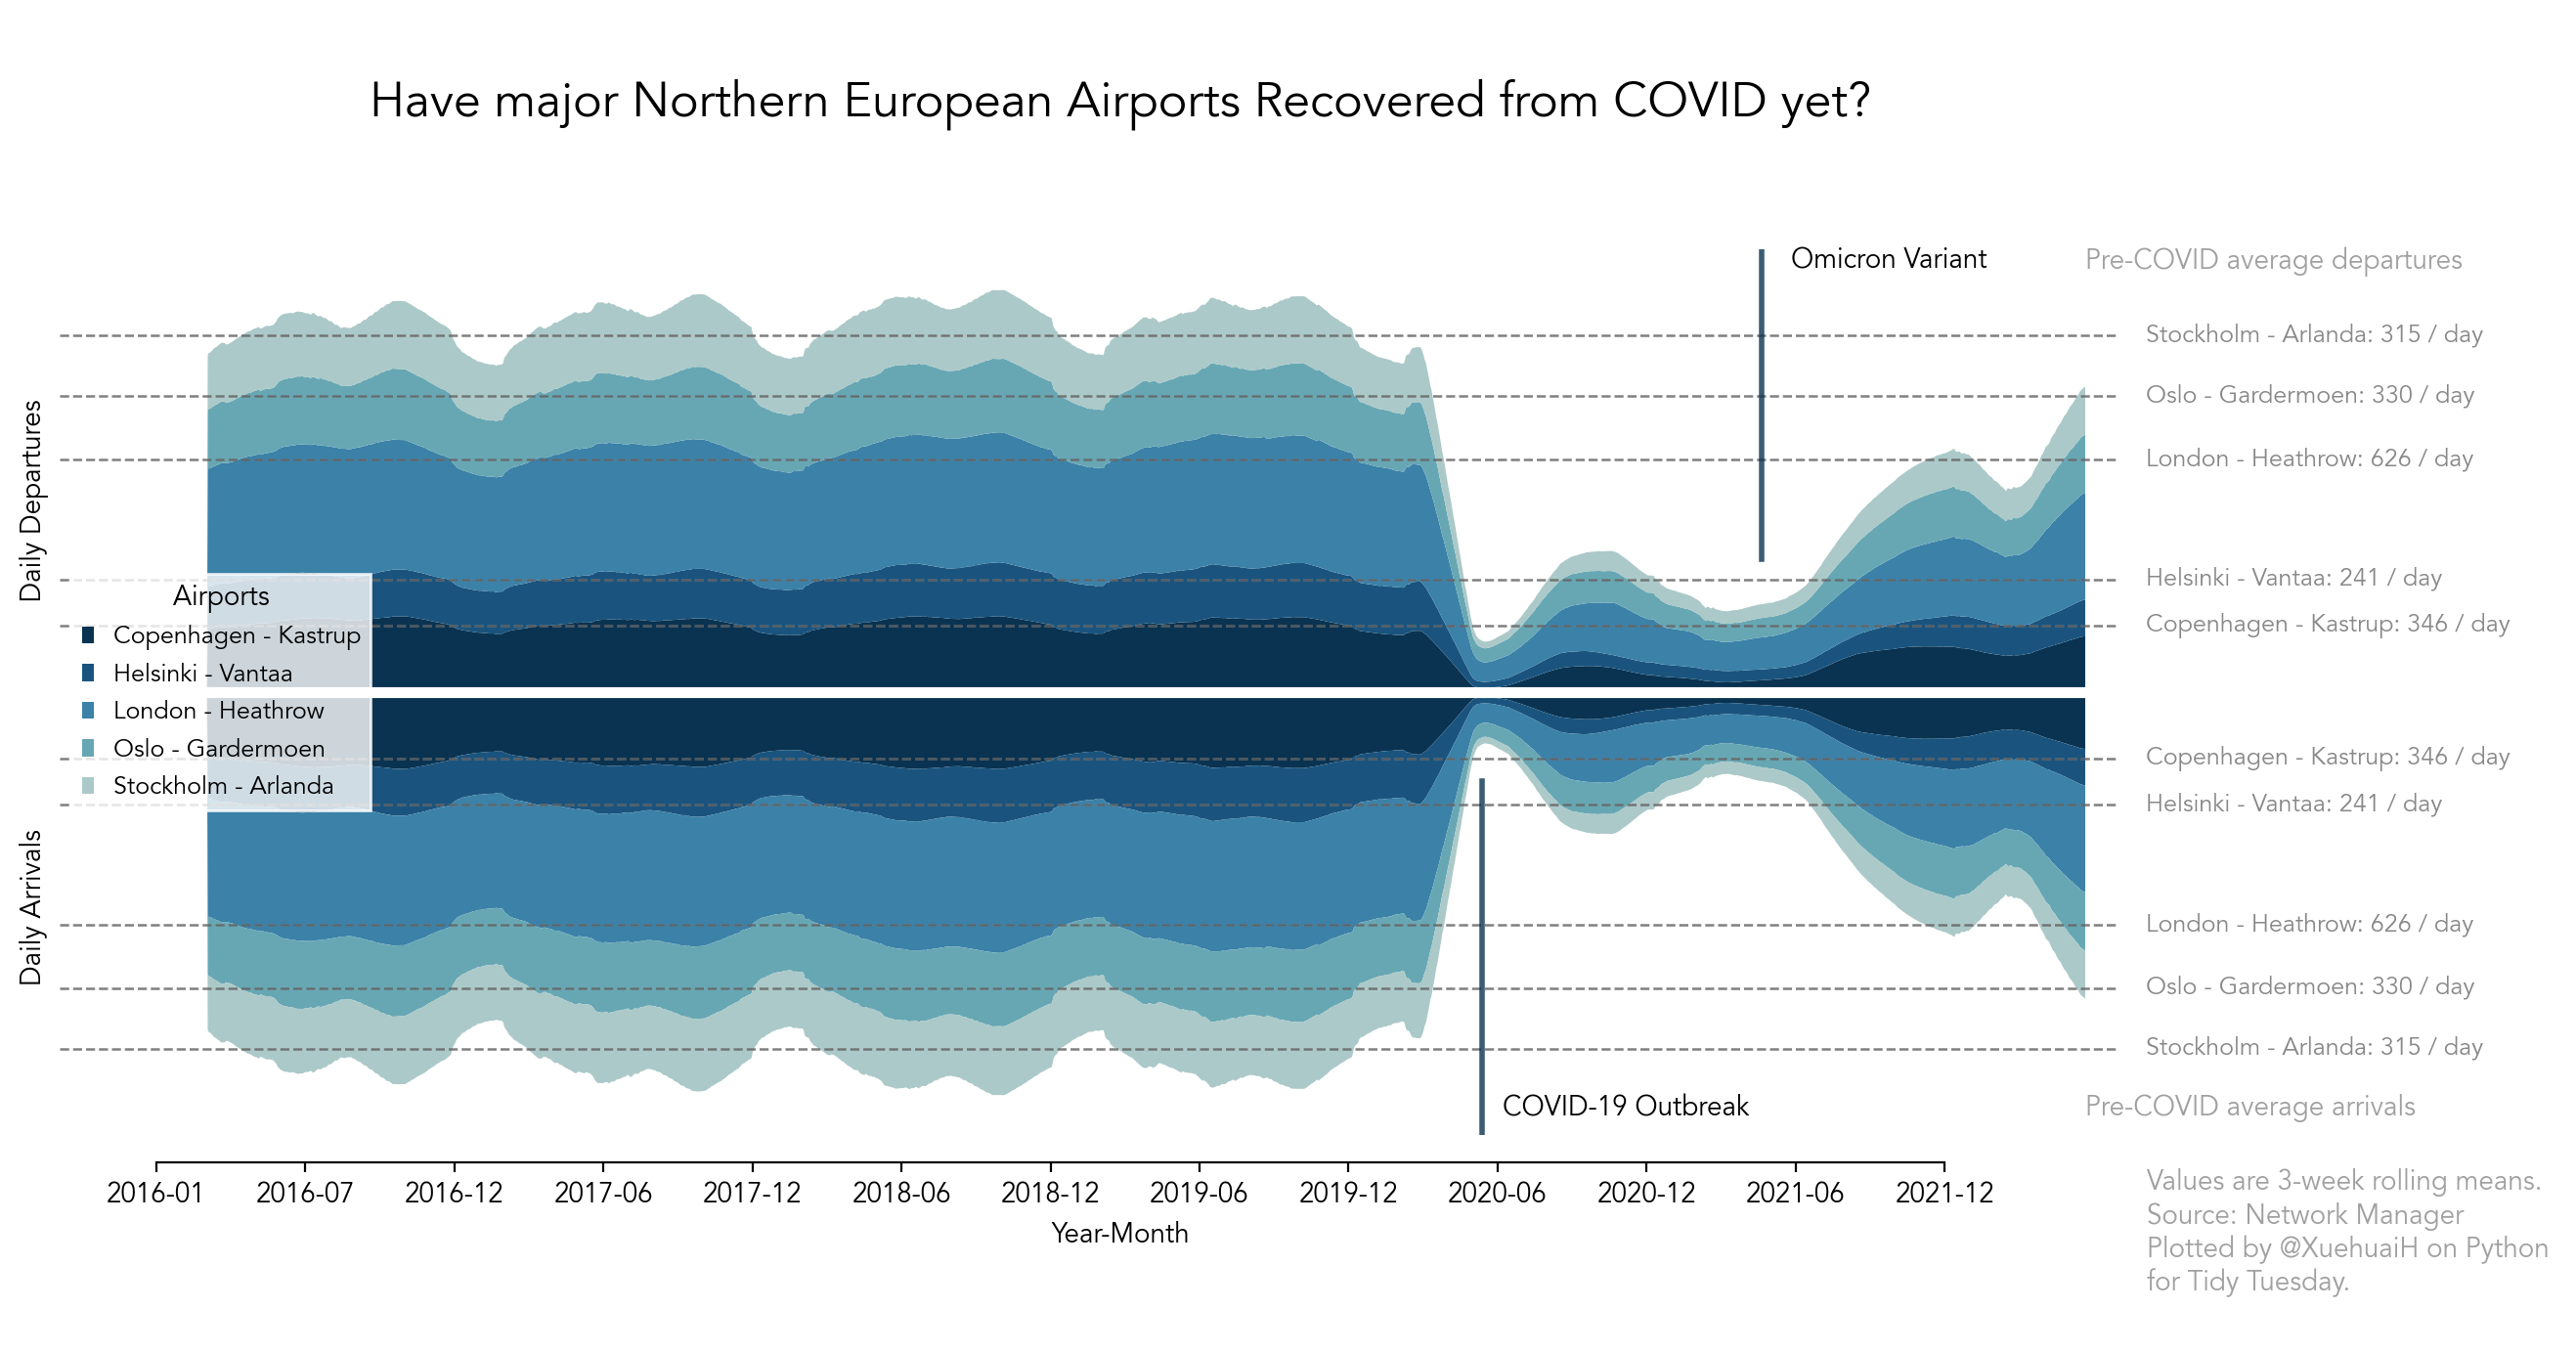

In [411]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 6),
                       dpi=200)

# Cmap
colorlist = met.met_brew(name="Hokusai2", 
                      n=len(dfd.columns), 
                      brew_type="continuous")[::-1] #cmap


#month-day
ymd = pd.date_range('2016-01-01', 
                    '2022-06-01').strftime('20%y-%m-%d')[-1 * len(dfd):]


# Plot
# Depts
ax.stackplot(ymd, 
             [dfd[dfd.columns[i]] for i in range(len(dfd.columns))],
             labels=dfd.columns,
             baseline="zero",
             colors=colorlist,
             edgecolor=(1,1,1,0)
             )
# Arrivals
ax.stackplot(ymd, 
             np.array([dfa[dfa.columns[i]] 
              for i in range(len(dfa.columns))]) * -1, # Invert
             #labels=dfa.columns,  # No need for duplicate labelling
             baseline="zero",
             colors=colorlist,
             edgecolor=(1,1,1,0)
             )


# Annotations
ax.axhline(0,
           color='w',
           ls='-',
           linewidth=4)

hlinecoord = 0
for i in range(len(bcarrs)):
  hlinecoord += bcarrs[i]
  ax.axhline(hlinecoord, color="w", 
           ls="--",
           linewidth=0.9,
           alpha=0.6,
           xmin=0,
           xmax=0.97)
  ax.axhline(hlinecoord, color="k", 
           ls="--",
           linewidth=0.9,
           alpha=0.5,
           xmin=0.,
           xmax=0.97)
  ax.text(ymd[-1], hlinecoord,
          f'         {bcarrs.index[i]}: {-1*int(bcarrs[i])} / day',
          ha='left',
          va='center',
          fontsize=9,
          color='#888888')
  
hlinecoord = 0
for i in range(len(bcdeps)):
  hlinecoord += bcdeps[i]
  ax.axhline(hlinecoord, color="w", 
           ls="--",
           linewidth=0.9,
           alpha=0.6,
           xmin=0,
           xmax=0.97)
  ax.axhline(hlinecoord, color="k", 
           ls="--",
           linewidth=0.9,
           alpha=0.5,
           xmin=0.,
           xmax=0.97,)
  ax.text(ymd[-1], hlinecoord,
          f'         {bcdeps.index[i]}: {int(bcdeps[i])} / day',
          ha='left',
          va='center',
          fontsize=9,
          color='#888888')
  
ax.axvline(ymd[1610], 
           color=colorlist[0], 
           ls="-",
           linewidth=2,
           alpha=0.8,
           ymax=0.4)
ax.text(ymd[1635],
        bcarrs.sum() - 350,
        'COVID-19 Outbreak')

ax.axvline(ymd[1950], 
           color=colorlist[0], 
           ls="-",
           linewidth=2,
           alpha=0.8,
           ymin=0.65)
ax.text(ymd[1985],
        bcdeps.sum() + 350,
        'Omicron Variant')

ax.text('2022-7-10',
        bcarrs.sum() - 350,
        'Pre-COVID average arrivals',
        color='#a0a0a0')
ax.text('2022-7-10',
        bcdeps.sum() + 350,
        'Pre-COVID average departures',
        color='#a0a0a0')

ax.text('2022-3-1',
        bcarrs.sum() - 450,
        '''
        Values are 3-week rolling means.
        Source: Network Manager
        Plotted by @XuehuaiH on Python 
        for Tidy Tuesday.
        ''',
        #ha='center',
        va='top',
        color='#a0a0a0')


# Tweaking

plt.xticks(ymd[::181],
           labels=pd.date_range('2016-01-01', 
                                '2022-06-01')
           .strftime('20%y-%m')[-1 * len(dfd)::181],
           #rotation=90,
           )

plt.yticks([])
plt.ylabel('Daily Arrivals                              Daily Departures')
plt.xlabel('Year-Month')
plt.title('''
Have major Northern European Airports Recovered from COVID yet?

''',
          fontdict={'size': 18})

plt.legend(ncol=1,
           frameon=True,
           fancybox=False,
           edgecolor=(1,1,1,0),
           fontsize=9,
           loc='center left',
           handlelength=0.5,
           title='Airports')

sns.despine(offset=10, 
            left=True,
            trim=True,
            )

plt.show()